In [58]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from statsmodels.tsa.stattools import adfuller
  
plt.style.use('fivethirtyeight')

In [5]:
filename = '../datas/apple.csv'
stock = pd.read_csv(filename)
stock.index = pd.to_datetime(stock.index)
stock = stock.asfreq(freq='D')
stock = stock.fillna(method='bfill')
stock.head()

,AAPL
2013-03-11,13.506429
2013-03-12,13.215249
2013-03-13,13.212777
2013-03-14,13.340788
2013-03-15,13.685024


Text(0.5, 0, 'Date')

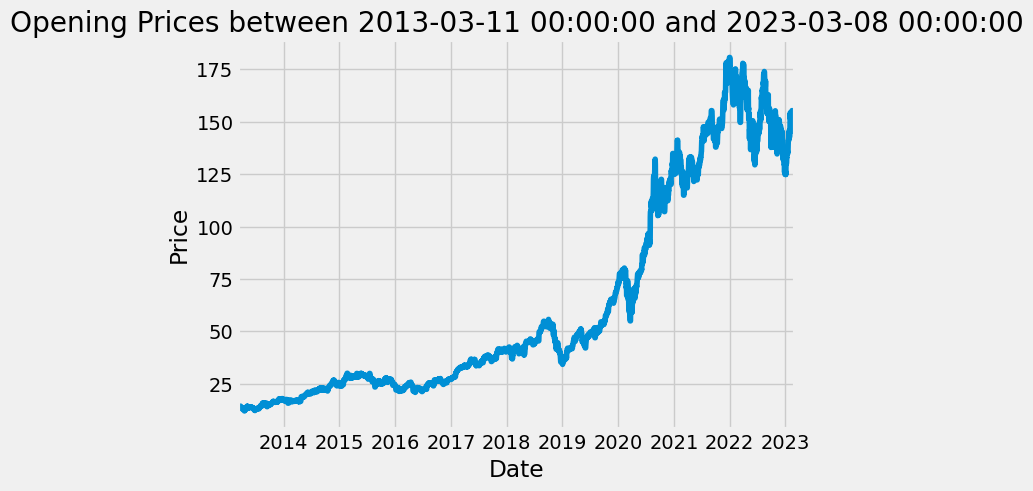

In [6]:
import matplotlib.pyplot as plt
start_date = stock.first_valid_index()
end_date = stock.last_valid_index()
plt.title(f'Opening Prices between {start_date} and {end_date}')
stock['AAPL'].plot()
plt.ylabel('Price')
plt.xlabel('Date')

## Train / Test split on a date ( 30 days prior to end of dataset)

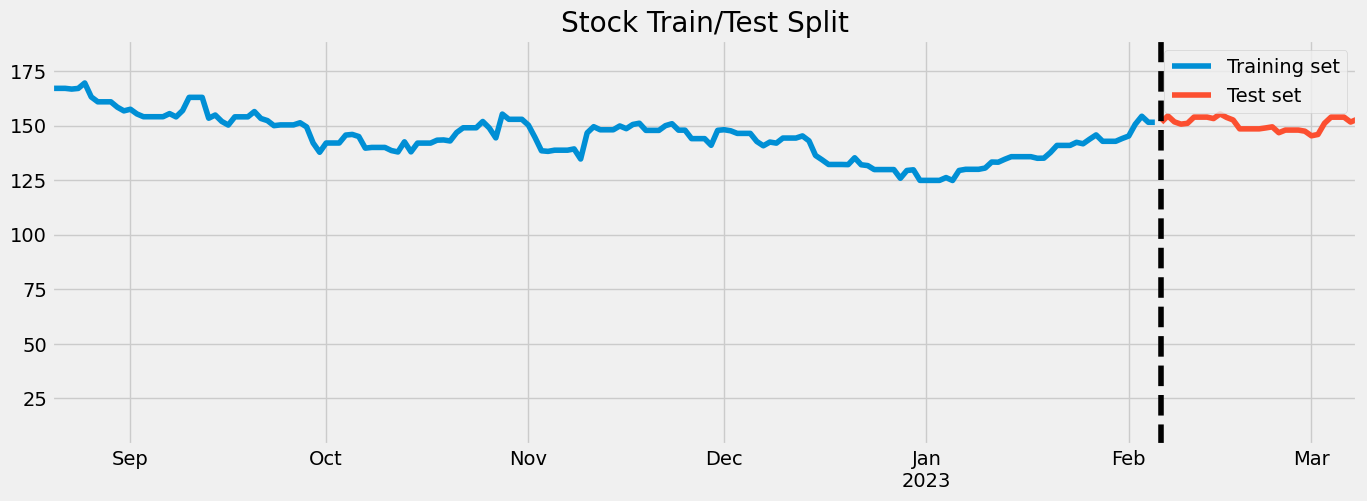

In [7]:
split_date = pd.to_datetime(stock.last_valid_index()) - timedelta(days=30)
train = stock.loc[stock.index < split_date]
test = stock.loc[stock.index >= split_date]
fig, ax = plt.subplots(figsize=(15,5))

train.plot(ax=ax, label='train', title='Stock Train/Test Split')
test.plot(ax=ax, label='test')
plt.xlim([end_date - timedelta(days=200), end_date])
ax.axvline(split_date, color='black', linestyle='--')
ax.legend(['Training set', 'Test set'])

## Features Creation

In [8]:
def create_features(data: pd.DataFrame):
    data = data.copy()
    # from autocorrelation analysis, no seasonal variation , but adding year and month to test.
    data['year'] = data.index.year
    data['month'] = data.index.month
    # from partial autocorrelation analysis, lag 1, lag 2.
    data['lag_1'] = data[data.columns[0]].shift(1)
    data['lag_2'] = data[data.columns[0]].shift(2)
    return(data)


In [9]:
# Create features on train and test, and selection of target and features
train = create_features(train)
test = create_features(test)

FEATURES = ['year', 'month', 'lag_1', 'lag_2']
TARGET = stock.columns[0]

In [10]:
test.head()

,AAPL,year,month,lag_1,lag_2
2023-02-06,151.498688,2023,2,NaN,NaN
2023-02-07,154.414230,2023,2,151.498688,NaN
2023-02-08,151.688400,2023,2,154.414230,151.498688
2023-02-09,150.639999,2023,2,151.688400,154.414230
2023-02-10,151.009995,2023,2,150.639999,151.688400


In [11]:
# Splitting on X and y for train and test sets.
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

## 1. Machine Learning Model

### Create Model: XGBoost

In [12]:
# Create the model and evaluate on train and test sets.
model = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
model.fit(X_train,y_train, 
            eval_set=[(X_train, y_train),(X_test, y_test)],
            verbose=True
        )

[0]	validation_0-rmse:55.50950	validation_1-rmse:108.28700
[1]	validation_0-rmse:38.98230	validation_1-rmse:78.31269
[2]	validation_0-rmse:27.38229	validation_1-rmse:57.95479
[3]	validation_0-rmse:19.24830	validation_1-rmse:44.83886
[4]	validation_0-rmse:13.55021	validation_1-rmse:36.58548
[5]	validation_0-rmse:9.56034	validation_1-rmse:31.51522
[6]	validation_0-rmse:6.77773	validation_1-rmse:28.62735
[7]	validation_0-rmse:4.84961	validation_1-rmse:27.00956
[8]	validation_0-rmse:3.52984	validation_1-rmse:26.13527
[9]	validation_0-rmse:2.63611	validation_1-rmse:25.66066
[10]	validation_0-rmse:2.04504	validation_1-rmse:25.41424
[11]	validation_0-rmse:1.67056	validation_1-rmse:25.29904
[12]	validation_0-rmse:1.43613	validation_1-rmse:25.23586
[13]	validation_0-rmse:1.29704	validation_1-rmse:25.17696
[14]	validation_0-rmse:1.22064	validation_1-rmse:25.14313
[15]	validation_0-rmse:1.16818	validation_1-rmse:25.12474
[16]	validation_0-rmse:1.13282	validation_1-rmse:25.09236
[17]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Graph of features importance

<AxesSubplot: title={'center': 'FEATURES Importance'}>

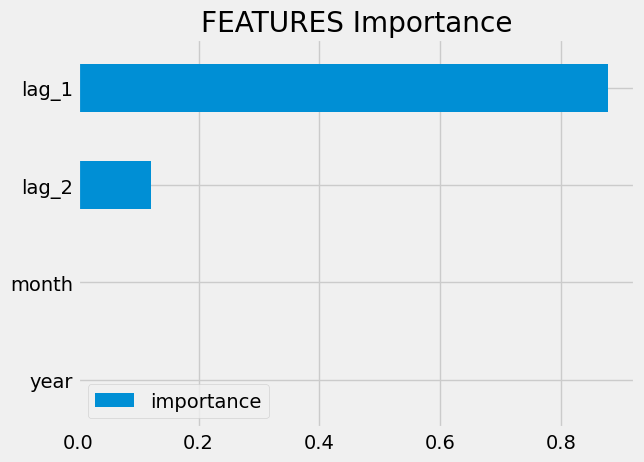

In [13]:
fi = pd.DataFrame(data=model.feature_importances_, index=model.feature_names_in_ , columns=['importance'])
fi.sort_values(by='importance', ascending=True).plot(kind='barh', title='FEATURES Importance')

## Prediction on test set

In [30]:

test.loc[:,'prediction'] = model.predict(X_test)
data = stock.merge(test[['prediction']], how='left', left_index=True, right_index=True)
data.head()

C:\Users\test\AppData\Local\Temp\ipykernel_21484\693819548.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:,'prediction'] = model.predict(X_test)


,AAPL,prediction
2013-03-11,13.506429,NaN
2013-03-12,13.215249,NaN
2013-03-13,13.212777,NaN
2013-03-14,13.340788,NaN
2013-03-15,13.685024,NaN


In [28]:
# Score on test set
score = np.sqrt(mean_squared_error(y_test, test['prediction']))
print(f'RMSE Score on test set: {score:0.2f}')

RMSE Score on test set: 24.99


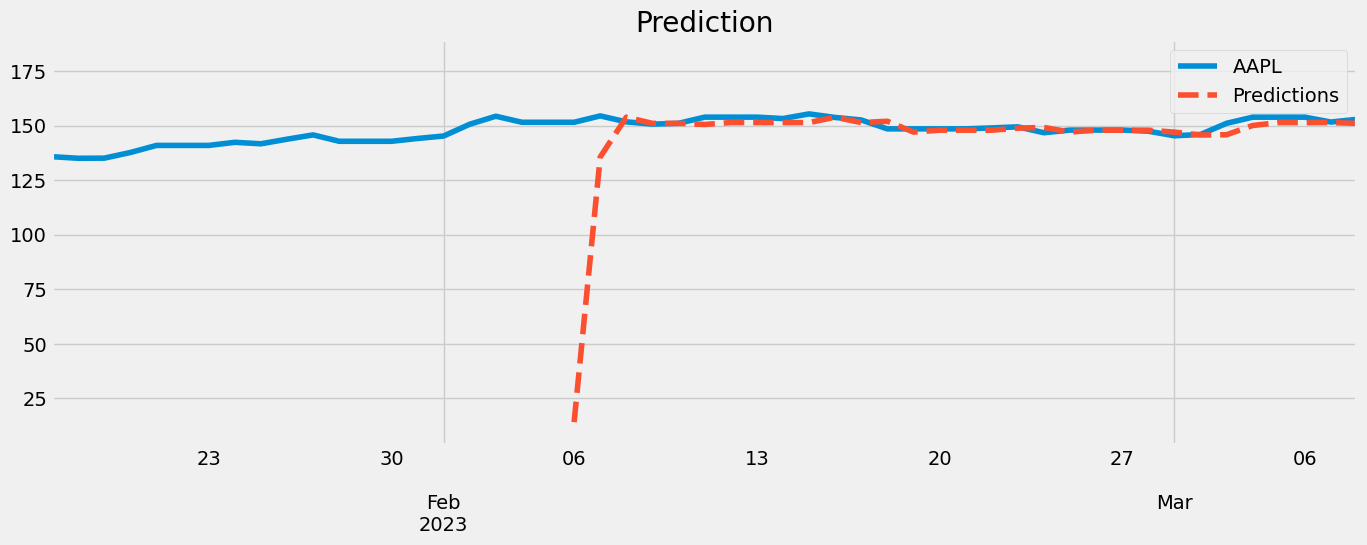

In [31]:
# Plot comparison of prediction results and test set.

ax = stock[[stock.columns[0]]].plot(figsize =(15,5))
test['prediction'] .plot(ax=ax, style='--', label='2 lags Prediction')
plt.xlim([end_date - timedelta(days=50), end_date])
ax.set_title('Prediction')
ax.legend([stock.columns[0], 'Predictions'])

### Prediction on future lag

## 2. Stats models

- reduce time window to 1 week
- reduce duration of datas: 1-5 years
- reduce duration of datas for stat models: effect on prediction?
- fit the model with all datas for future prediction
- compare prediction with real values ( add prediction in )

### Analysis: seasonal decompose.

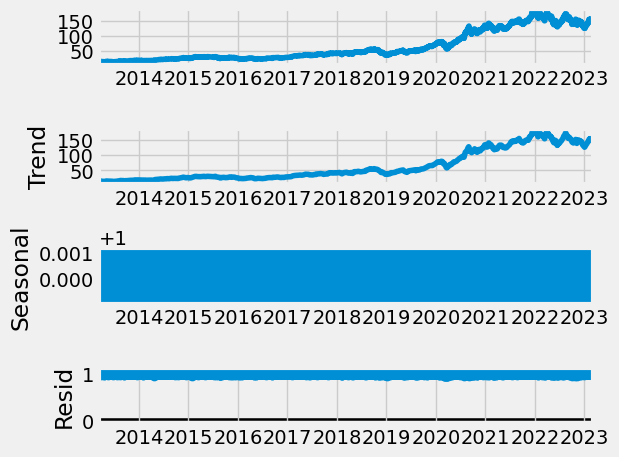

In [33]:
seasonal_decompose(stock, model="multiplicative").plot()
decompose_results = seasonal_decompose(stock, model="multiplicative", extrapolate_trend=30)
# decompose_results.trend

### Stationarity and noise distributions analysis.

In [65]:
# Sationarity
adf_test = ADFTest(alpha=0.05)
stat_test = 'is' if adf_test.should_diff(stock)[1] else 'is not'
print(f'This time serie {stat_test} stationary')
adf_test.should_diff(stock)


This time serie is stationary


(0.6243189858159848, True)

In [72]:
res = adfuller(stock)
# print(res[0],res[4])
 
# Printing the statistical result of the adfuller test
print('Augmneted Dickey_fuller Statistic: %f' % res[0])
print('p-value: %f' % res[1])
 
# printing the critical values at different alpha levels.
print('critical values at different levels:')
for k, v in res[4].items():
    print('\t%s: %.3f' % (k, v))
if res[0] < res[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")    

Augmneted Dickey_fuller Statistic: 0.047396
p-value: 0.962281
critical values at different levels:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Failed to Reject Ho - Time Series is Non-Stationary


In [69]:
stock.head()

,AAPL
2013-03-11,13.506429
2013-03-12,13.215249
2013-03-13,13.212777
2013-03-14,13.340788
2013-03-15,13.685024


In [71]:
# getting the count to split the dataset
# into 3 parts
parts = int(len(stock)/3)
 
# splitting the data into three parts.
part_1, part_2, part_3 = stock[0:parts], stock[parts:(parts*2)], stock[(parts*2):(parts*3)]
 
# calculating the mean of the separated three
# parts of data individually.
mean_1, mean_2, mean_3 = part_1.mean(), part_2.mean(), part_3.mean()
 
# calculating the variance of the separated three
# parts of data individually.
var_1, var_2, var_3 = part_1.var(), part_2.var(), part_3.var()
 
# printing the mean of three groups
print('mean1=%f, mean2=%f, mean2=%f' % (mean_1, mean_2, mean_3))
 
# printing the variance of three groups
print('variance1=%f, variance2=%f, variance2=%f' % (var_1, var_2, var_3))

mean1=21.510714, mean2=40.092582, mean2=126.962335
variance1=26.027369, variance2=80.622588, variance2=1041.452415


C:\Users\test\AppData\Roaming\Python\Python311\site-packages\matplotlib\axes\_base.py:2539: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


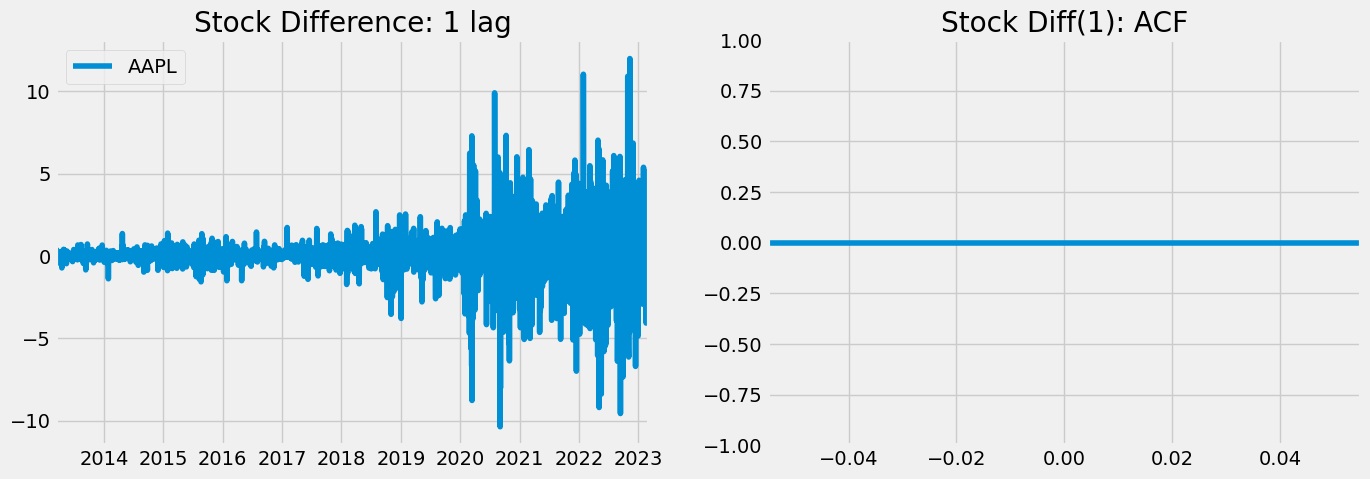

In [51]:
# Diff to remove trend
stock_diff = stock.diff()
# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))

ax1.set_title('Stock Difference: 1 lag')
stock_diff.plot(ax=ax1)

sm.graphics.tsa.plot_acf(stock_diff, lags=50, ax=ax2, title='Stock Diff(1): ACF')

plt.show()
plt.close()


C:\Users\test\AppData\Roaming\Python\Python311\site-packages\matplotlib\axes\_base.py:2539: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


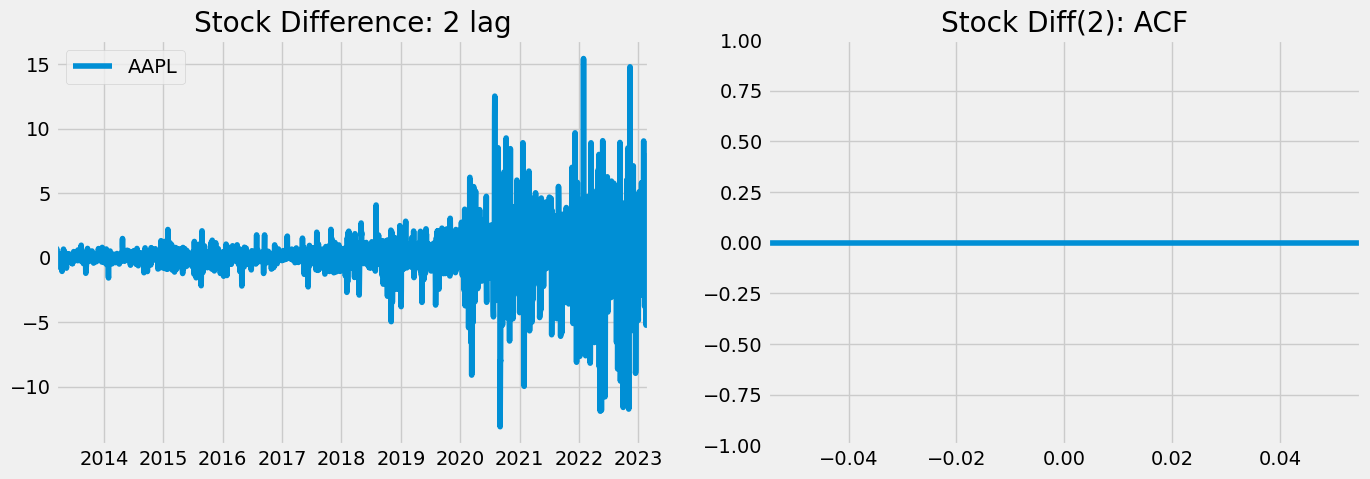

In [56]:
# Diff to remove trend
stock_diff = stock.diff(2)
# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))

ax1.set_title('Stock Difference: 2 lag')
stock_diff.plot(ax=ax1)

sm.graphics.tsa.plot_acf(stock_diff, lags=50, ax=ax2, title='Stock Diff(2): ACF')

plt.show()
plt.close()


## ACF and PACF

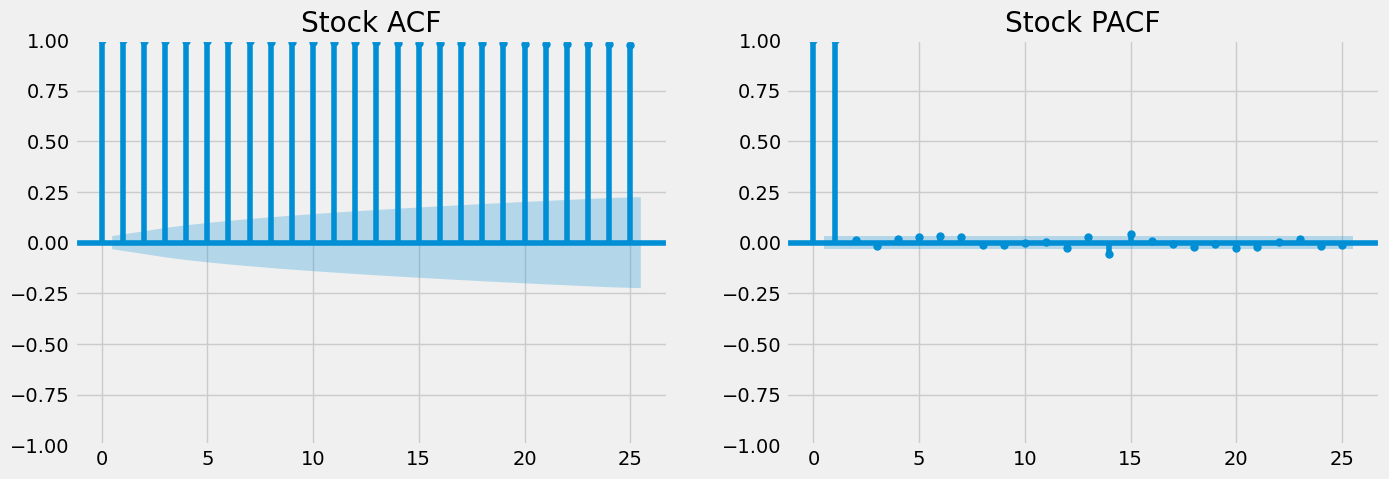

In [55]:
# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))

sm.graphics.tsa.plot_acf(stock, lags=25,ax=ax1, title='Stock ACF')
sm.graphics.tsa.plot_pacf(stock, lags=25,ax=ax2, title='Stock PACF')

plt.show()
plt.close()


## 👉Step5: Train and Test split

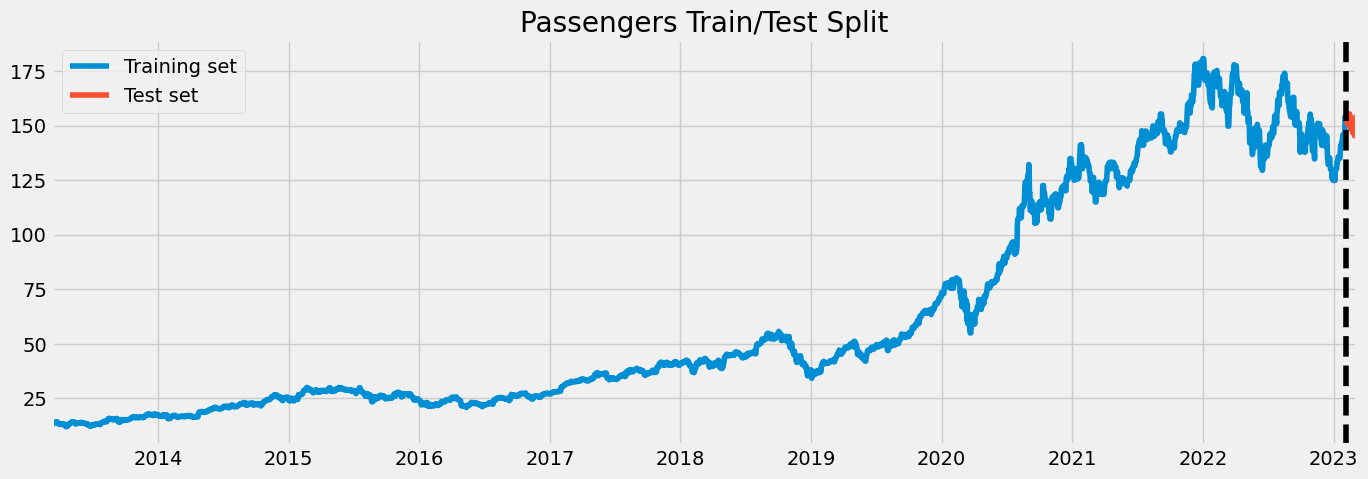

In [20]:
train = stock.loc[stock.index < split_date]
test = stock.loc[stock.index >= split_date]
fig, ax = plt.subplots(figsize=(15,5))

train.plot(ax=ax, label='train', title='Passengers Train/Test Split')
test.plot(ax=ax, label='test')
ax.axvline(split_date, color='black', linestyle='--')
ax.legend(['Training set', 'Test set'])

In [82]:
opt_arima_model = auto_arima(train, start_p=0, d=0,
                         start_q=0,
                         max_p=5, max_d=5, max_q=5,
                        #  start_P=0, D=1,
                        #  start_Q=0, max_P=5, max_D=5, 
                        #  max_Q=5, 
                         m=12, seasonal=False, 
                         error_action='warn',trace=True, 
                         suppress_warnings=True, stepwise=True, 
                         random_state=20, n_fits=50)

C:\Users\test\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=41941.138, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=12349.102, Time=0.41 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=12336.248, Time=0.61 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.50 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=12334.709, Time=0.78 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.71 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=12335.706, Time=1.15 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=12337.390, Time=1.18 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=12334.822, Time=0.92 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=1.15 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=12337.082, Time=1.44 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=12335.534, Time=2.13 sec

Best model:  ARIMA(3,0,1)(0,0,0)[0]          
To

In [83]:
opt_arima_model.model_order

AttributeError: 'ARIMA' object has no attribute 'model_order'

In [80]:
pred_horizon = test.shape[0]
y_prediction, conf_int  = opt_arima_model.predict(pred_horizon,return_conf_int=True,alpha=0.05)
prediction = pd.DataFrame({'predicted_': y_prediction, 'low_int': conf_int[:,0], 'high_int': conf_int[:,1]}, index=test.index)
# prediction.columns = ['predicted_passenger']
# prediction

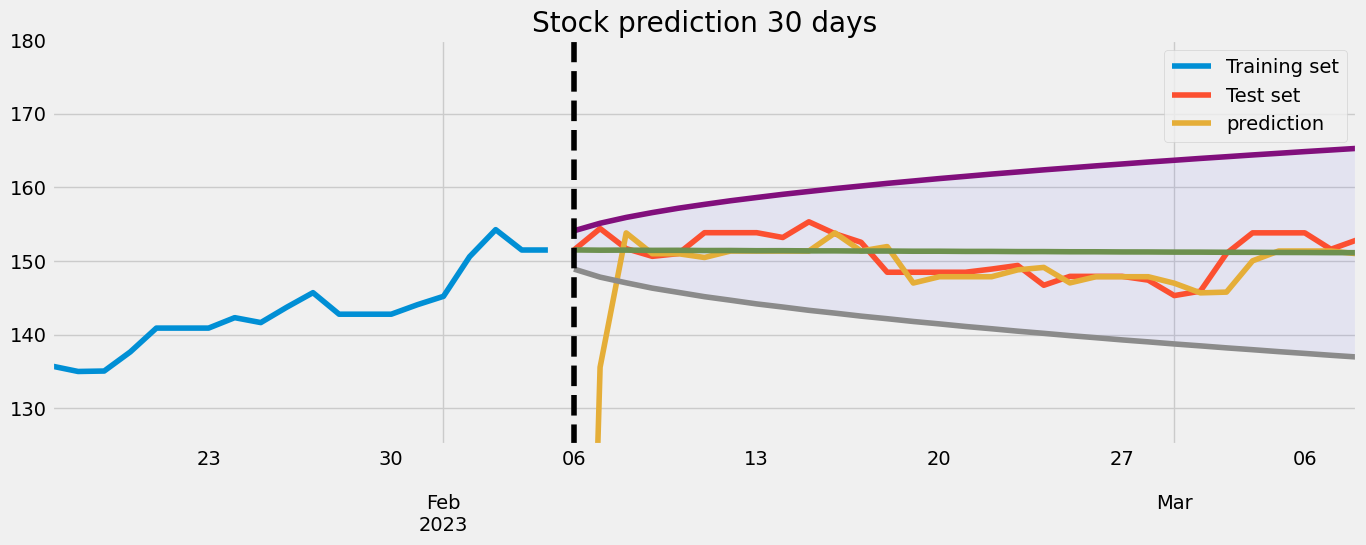

In [77]:
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='train', title='Stock prediction 30 days')
test.plot(ax=ax, label='test')
prediction.plot(ax=ax, label='predicted_')
ax.fill_between(prediction.index, (prediction['low_int']), (prediction['high_int']), color='b', alpha=.05, linewidth=0)
ax.axvline(split_date, color='black', linestyle='--')
plt.xlim([end_date - timedelta(days=50), end_date])
plt.ylim([125, 180])
ax.legend(['Training set', 'Test set', 'prediction'])
plt.show()
plt.close()